# CIFAR-10图像分类

In [2]:
!export http_proxy="http://127.0.0.1:7890"
!export https_proxy="http://127.0.0.1:7890"

using device:cuda:7
Epoch [1/10], Average Loss: 2.2503
Epoch [2/10], Average Loss: 1.8573
Epoch [3/10], Average Loss: 1.7659
Epoch [4/10], Average Loss: 1.7213
Epoch [5/10], Average Loss: 1.7108
Epoch [6/10], Average Loss: 1.6787
Epoch [7/10], Average Loss: 1.6707
Epoch [8/10], Average Loss: 1.6605
Epoch [9/10], Average Loss: 1.6524
Epoch [10/10], Average Loss: 1.6526


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


Accuracy of the model on the 10000 test images: 41.05 %


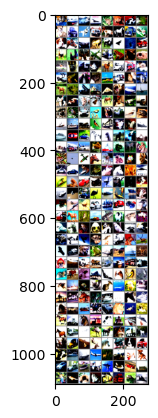

Predicted:  cat   ship  ship  ship  frog  cat   car   cat   frog  car   ship  truck frog  horse truck ship  dog   truck ship  frog  horse plane ship  car   bird  frog  frog  horse car   frog  dog   deer  frog  cat   truck horse frog  truck car   cat   ship  frog  frog  frog  plane truck frog  ship  frog  deer  truck ship  frog  frog  ship  ship  horse cat   cat   horse deer  dog   horse bird  cat   frog  car   plane cat   horse frog  dog   ship  ship  truck bird  truck cat   dog   ship  ship  car   car   cat   bird  horse cat   plane ship  truck ship  frog  ship  cat   deer  frog  frog  plane plane truck cat   cat   cat   cat   car   car   ship  cat   cat   dog   bird  truck frog  cat   car   horse plane cat   dog   truck ship  cat   car   cat   plane frog  cat   frog  cat   frog  deer  car   ship  car   cat   horse truck ship  deer  ship  deer  cat   frog  truck ship  horse cat   dog   cat   cat   truck truck cat   plane plane cat   cat   truck truck deer  bird  car   cat   frog  ship

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device=torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(f'using device:{device}')
batch_size=256
learning_rate=0.01
num_epochs=10

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
])#(R,G,B)的均值和标准差

train_set=torchvision.datasets.CIFAR10(root='./data',train=True,download=False,transform=transform)
trian_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)
test_set=torchvision.datasets.CIFAR10(root='./data',train=False,download=False,transform=transform)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout=nn.Dropout(0.25)
        self.fc1=nn.Linear(64*8*8,512)
        self.fc2=nn.Linear(512,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,64*8*8)
        x=self.dropout(x)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=self.fc2(x)
        return x
    
model=SimpleCNN().to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

total_step=len(trian_loader)
for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    for i,(images,label) in enumerate(trian_loader):
        images=images.to(device)
        label=label.to(device)
        output=model(images)
        loss=criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        if (i+1) % 500 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/total_step:.4f}')

model.eval()
with torch.no_grad():
    correct=0
    total=0
    for images,label in test_loader:
        images=images.to(device)
        label=label.to(device)
        output=model(images)
        _,predicted=torch.max(output,1)
        total+=label.size(0)
        correct+=(predicted==label).sum().item()
    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')

def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter=iter(test_loader)
images,label=next(dataiter)
images,label=images.to(device),label.to(device)

imshow(torchvision.utils.make_grid(images.cpu()))

output=model(images)
_,predicted=torch.max(output,1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(batch_size)))

# 结果分析
模型太简单（比如只有几层全连接或卷积）

训练轮数不够（10 个 epoch 对 CIFAR‑10 来说偏少）

学习率、优化器、数据增强等超参数没调好

归一化或预处理不匹配（比如均值方差不对）